In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,0.834031,level_426,level_43,level_65,level_263,level_342,level_285,level_20,level_18,level_210,...,level_464,level_451,level_60,level_98,level_338,level_91,level_474,level_8,level_249,level_94
1,6.532119,level_49,level_290,level_451,level_327,level_68,level_491,level_370,level_489,level_189,...,level_232,level_303,level_360,level_80,level_52,level_37,level_241,level_487,level_464,level_225
2,10.830863,level_71,level_225,level_471,level_153,level_105,level_265,level_26,level_325,level_281,...,level_494,level_427,level_402,level_463,level_152,level_358,level_303,level_326,level_182,level_126
3,9.671572,level_365,level_79,level_240,level_100,level_105,level_397,level_214,level_361,level_488,...,level_182,level_359,level_39,level_193,level_106,level_477,level_57,level_112,level_231,level_375
4,-0.598936,level_83,level_405,level_434,level_253,level_241,level_384,level_258,level_416,level_59,...,level_451,level_86,level_70,level_81,level_131,level_41,level_73,level_124,level_310,level_104


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-9.134289,3.616813,-1.922091,9.149251,6.917876,2.481793,3.810909,-7.032625,-2.286547,-1.452769,...,7.902956,-8.378496,16.823735,4.660438,-6.642357,0.411564,6.811028,-2.996288,2.886407,1.840406
1,-3.950491,-4.841189,-2.359791,3.060085,1.304359,-17.635604,-1.663766,3.214819,0.636117,-5.541811,...,1.214511,6.895461,-0.071510,-4.234486,2.412430,-4.772674,0.903950,2.739963,0.257170,12.012381
2,-6.243243,1.283025,-9.227248,-9.583342,-12.152500,0.145487,4.405919,11.577187,5.040525,-10.272424,...,-1.420980,-16.907093,-17.968110,-0.025155,9.008094,4.435473,16.982190,7.036392,-2.762734,2.806693
3,8.007012,-6.703093,1.572712,-2.744239,-2.982598,-0.207466,9.425817,-1.490682,3.484824,6.684575,...,-10.369942,-5.044995,10.233528,-9.730735,-1.499823,8.100559,-4.156410,5.748140,11.622836,2.641425
4,5.369134,-10.345717,-8.671152,4.388359,-7.027553,-3.575886,-5.864225,-17.345613,0.923407,-4.068228,...,1.253297,-12.541678,4.063199,-5.565398,-2.500995,-1.466274,3.538634,-12.850444,3.982502,-10.326822


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-4.463648,2.943538,-0.966341,5.800119,4.626503,2.107273,1.721266,-2.045011,-1.560517,-1.015497,...,4.695867,-2.821768,14.197295,3.053112,-3.759827,0.321718,4.808598,-0.799779,2.297966e+00,1.398958
1,-3.386256,-4.095834,-1.399101,1.730856,1.038241,-4.578913,-0.669625,2.865976,0.444743,-4.157960,...,0.886294,3.547946,-0.066981,-2.483488,0.863822,-2.079849,0.690437,2.032611,1.654260e-01,8.804843
2,-3.827796,0.870344,-6.398940,-9.064910,-3.760274,0.067765,2.404184,6.805021,3.128482,-5.387218,...,-0.875032,-10.602616,-8.793227,-0.015591,6.458328,2.949478,8.764910,4.513636,-2.089298e+00,0.923558
3,5.386911,-2.488384,0.719552,-1.976661,-2.097284,-0.135704,6.162170,-1.128098,2.888991,6.064453,...,-5.820237,-1.788539,6.337150,-3.306883,-0.883650,5.353483,-3.732535,4.453023,-1.110223e-16,1.080806
4,3.282273,-7.590459,-6.983269,1.425097,-2.327027,-2.731831,-5.155014,0.000000,0.121334,-3.335141,...,0.941169,-6.191253,1.882996,-2.668398,-1.131493,-0.924390,2.171008,-5.438328,2.763649e+00,-8.091196


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-9.786984,-5.216685,-2.286482,7.743705,-1.110223e-16,0.873349,0.000000,-3.091814,-9.898098,-0.215001,...,1.951243,-15.398049,17.791757,1.685998,-1.955540,-2.030288,4.363190,-1.581878,0.885244,2.097198
1,-3.718024,-5.518030,-0.745428,1.670840,5.617265e+00,-4.040061,-0.414207,1.877708,0.466506,-5.554000,...,1.367257,10.314581,-0.268606,-2.766649,0.000000,-5.509333,0.897261,2.347577,0.270603,3.842318
2,-0.863422,1.542596,-3.935362,-10.300994,-7.281440e-01,0.143363,12.408015,6.548365,3.385688,-9.960642,...,-5.012285,-19.092568,-10.163474,0.101137,6.929250,-1.214970,7.792418,4.341147,-2.286493,0.916063
3,4.449318,-6.136581,-22.167079,-2.868979,-2.175980e+00,-2.145833,1.687934,-4.062874,0.377361,5.227588,...,-14.866688,-2.754633,3.252308,-5.364099,3.499799,2.358296,-5.642774,3.240812,0.000000,6.015075
4,-0.433349,-8.801317,-4.264708,-0.273937,-1.110223e-16,-0.988724,-2.073904,0.000000,0.000000,-1.249171,...,4.061754,-1.526496,2.098235,0.289656,0.608192,0.085154,6.498352,-10.666425,2.989954,-7.289117


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.540897,0.518217,0.162593,0.207077,False
1,var_1_impact_code,0.500549,0.474101,0.121059,0.169472,False
2,var_2_impact_code,0.537101,0.516602,0.187877,0.184339,False
3,var_3_impact_code,0.526972,0.497490,0.167738,0.125967,False
4,var_4_impact_code,0.522030,0.494777,0.147058,0.178871,False
5,var_5_impact_code,0.527363,0.503448,0.176682,0.187028,False
6,var_6_impact_code,0.517172,0.494737,0.141904,0.156979,False
7,var_7_impact_code,0.549113,0.525406,0.198557,0.183254,False
8,var_8_impact_code,0.510948,0.485961,0.120040,0.160963,False
9,var_9_impact_code,0.530576,0.505315,0.162205,0.173534,False


(0.8339100733517998, 1.2087672071838295e-29)


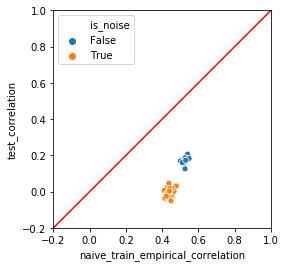

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8346807824529259, 9.61010288669078e-30)


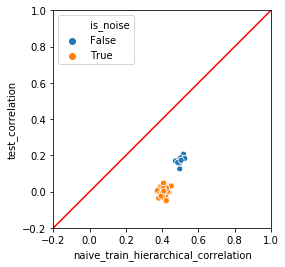

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.806615955484909, 2.0555627216262227e-26)


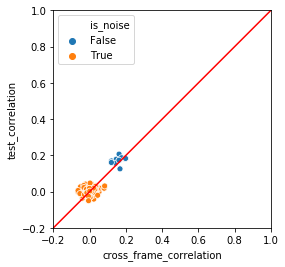

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,-0.014961,0.450340,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,0.000869,0.965047,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,0.002293,0.907886,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,-0.006627,0.738123,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,-0.005588,0.778007,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_6_impact_code',
 'noise_24_impact_code',
 'noise_80_impact_code',
 'noise_81_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,0.834031,4.225934,2.429763,2.134791,2.634871
1,6.532119,-2.270131,-0.768181,0.016635,-0.065262
2,9.671572,-1.699365,-1.941999,-2.261561,-4.576267
3,-5.585760,7.923252,4.117157,-1.589165,-2.024835
4,11.381830,-1.120069,-3.172071,-3.185869,-4.008925


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.188989725052076


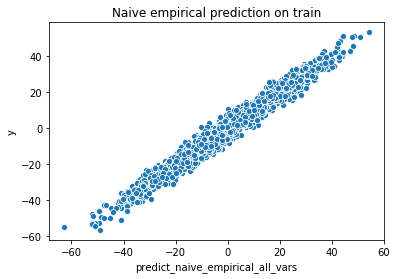

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.571689667844337


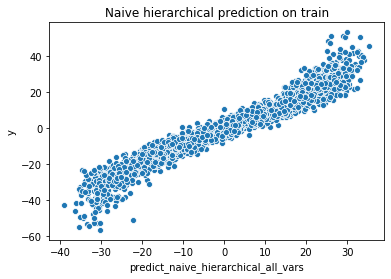

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.19956017271335


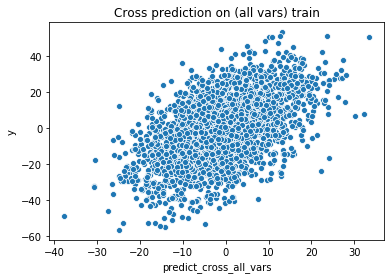

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.567591059097087


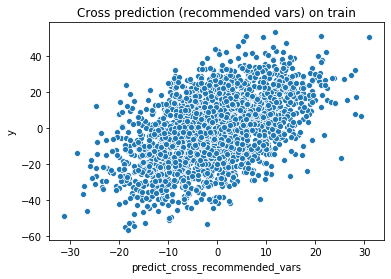

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.738418250256597


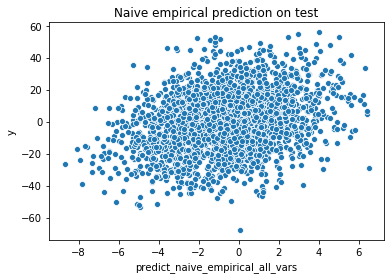

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.443844120671933


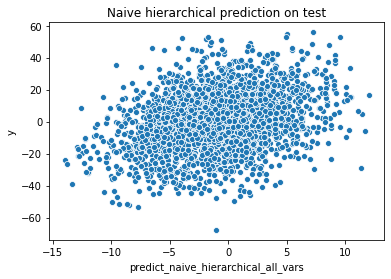

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.837802066429564


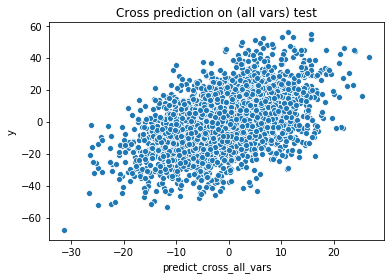

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.546232820266235


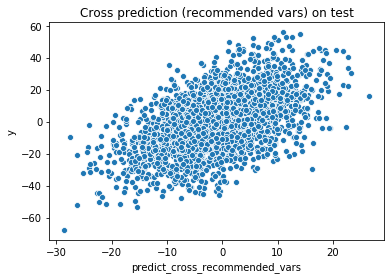

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     686.1
Date:                Tue, 13 Aug 2019   Prob (F-statistic):               0.00
Time:                        13:18:12   Log-Likelihood:                -6570.4
No. Observations:                2548   AIC:                         1.336e+04
Df Residuals:                    2437   BIC:                         1.401e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8273      0.065    -12.806      0.000      -0.954      -0.701
var_0_impact_code        0.0667      0.008      8.369      0.000       0.051       0.082
var_1_impact_code        0.0809      0.008      9.684      0.000       0.065       0.097
var_2_impact_code        0.0553      0.008      6.876      0.000       0.040       0.071
var_3_impact_code        0.0575      0.008      7.076      0.000       0.042       0.073
var_4_impact_code        0.0529      0.008      6.416      0.000       0.037       0.069
var_5_impact_code        0.0584      0.008      7.147      0.000       0.042       0.074
var_6_impact_code        0.0587      0.008      7.135      0.000       0.043       0.075
var_7_impact_code        0.0495      0.008      6.215      0.000       0.034       0.065
var_8_impact_code        0.0669      0.008      8.015      0.000       0.051       0.083
var_9_impact_code        0.0567      0.008      6.987      0.000       0.041       0.073
noise_0_impact_code      0.0233      0.009      2.472      0.014       0.005       0.042
noise_1_impact_code      0.0297      0.009      3.249      0.001       0.012       0.048
noise_2_impact_code      0.0481      0.009      5.226      0.000       0.030       0.066
noise_3_impact_code      0.0332      0.009      3.494      0.000       0.015       0.052
noise_4_impact_code      0.0399      0.009      4.328      0.000       0.022       0.058
noise_5_impact_code      0.0275      0.009      3.054      0.002       0.010       0.045
noise_6_impact_code      0.0471      0.009      5.285      0.000       0.030       0.065
noise_7_impact_code      0.0486      0.009      5.234      0.000       0.030       0.067
noise_8_impact_code      0.0442      0.009      4.764      0.000       0.026       0.062
noise_9_impact_code      0.0343      0.009      3.789      0.000       0.017       0.052
noise_10_impact_code     0.0419      0.009      4.639      0.000       0.024       0.060
noise_11_impact_code     0.0418      0.009      4.598      0.000       0.024       0.060
noise_12_impact_code     0.0334      0.009      3.591      0.000       0.015       0.052
noise_13_impact_code     0.0541      0.009      5.976      0.000       0.036       0.072
noise_14_impact_code     0.0353      0.009      3.812      0.000       0.017       0.053
noise_15_impact_code     0.0652      0.010      6.833      0.000       0.047       0.084
noise_16_impact_code     0.0385      0.009      4.249      0.000       0.021       0.056
noise_17_impact_code     0.0399      0.009      4.308      0.000       0.022       0.058
noise_18_impact_code     0.0414      0.009      4.468      0.000       0.023       0.060
noise_19_impact_code     0.0398      0.010      4.081      0.000       0.021       0.059
noise_20_impact_code     0.0432      0.009      4.792    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9687208425847973

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.060572501606116935

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     9.024
Date:                Tue, 13 Aug 2019   Prob (F-statistic):          8.98e-115
Time:                        13:18:13   Log-Likelihood:                -10549.
No. Observations:                2548   AIC:                         2.132e+04
Df Residuals:                    2437   BIC:                         2.197e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.1027      0.316     -3.495      0.000      -1.721      -0.484
var_0_impact_code        0.4005      0.045      8.878      0.000       0.312       0.489
var_1_impact_code        0.3457      0.048      7.172      0.000       0.251       0.440
var_2_impact_code        0.4124      0.045      9.095      0.000       0.323       0.501
var_3_impact_code        0.4097      0.046      8.858      0.000       0.319       0.500
var_4_impact_code        0.3708      0.049      7.547      0.000       0.274       0.467
var_5_impact_code        0.3992      0.046      8.656      0.000       0.309       0.490
var_6_impact_code        0.4279      0.048      8.955      0.000       0.334       0.522
var_7_impact_code        0.4107      0.045      9.177      0.000       0.323       0.499
var_8_impact_code        0.3307      0.048      6.826      0.000       0.236       0.426
var_9_impact_code        0.4157      0.045      9.215      0.000       0.327       0.504
noise_0_impact_code     -0.0663      0.060     -1.111      0.267      -0.183       0.051
noise_1_impact_code     -0.0222      0.057     -0.391      0.696      -0.133       0.089
noise_2_impact_code      0.0225      0.057      0.395      0.693      -0.089       0.134
noise_3_impact_code     -0.1028      0.058     -1.787      0.074      -0.216       0.010
noise_4_impact_code      0.0235      0.059      0.402      0.688      -0.091       0.138
noise_5_impact_code      0.0382      0.056      0.682      0.495      -0.072       0.148
noise_6_impact_code      0.0997      0.051      1.956      0.051      -0.000       0.200
noise_7_impact_code     -0.0572      0.057     -1.004      0.315      -0.169       0.054
noise_8_impact_code      0.0938      0.058      1.606      0.108      -0.021       0.208
noise_9_impact_code      0.0807      0.059      1.379      0.168      -0.034       0.196
noise_10_impact_code     0.0319      0.055      0.577      0.564      -0.077       0.140
noise_11_impact_code     0.0179      0.055      0.329      0.742      -0.089       0.125
noise_12_impact_code     0.1005      0.059      1.690      0.091      -0.016       0.217
noise_13_impact_code     0.0504      0.056      0.902      0.367      -0.059       0.160
noise_14_impact_code     0.0689      0.062      1.113      0.266      -0.053       0.190
noise_15_impact_code    -0.0469      0.061     -0.764      0.445      -0.167       0.073
noise_16_impact_code    -0.0346      0.054     -0.639      0.523      -0.141       0.072
noise_17_impact_code     0.0673      0.059      1.144      0.253      -0.048       0.183
noise_18_impact_code     0.0144      0.059      0.244      0.807      -0.102       0.131
noise_19_impact_code    -0.1550      0.060     -2.582      0.010      -0.273      -0.037
noise_20_impact_code     0.0380      0.057      0.662    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.289423488013575

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.2511008995541091

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     61.80
Date:                Tue, 13 Aug 2019   Prob (F-statistic):          3.90e-150
Time:                        13:18:13   Log-Likelihood:                -10610.
No. Observations:                2548   AIC:                         2.125e+04
Df Residuals:                    2533   BIC:                         2.134e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2355      0.310     -3.986      0.000      -1.843      -0.628
var_0_impact_code        0.4181      0.045      9.392      0.000       0.331       0.505
var_1_impact_code        0.3629      0.048      7.637      0.000       0.270       0.456
var_2_impact_code        0.4264      0.045      9.535      0.000       0.339       0.514
var_3_impact_code        0.4099      0.046      8.993      0.000       0.321       0.499
var_4_impact_code        0.3827      0.048      7.919      0.000       0.288       0.477
var_5_impact_code        0.4142      0.045      9.153      0.000       0.325       0.503
var_6_impact_code        0.4159      0.047      8.816      0.000       0.323       0.508
var_7_impact_code        0.4288      0.044      9.672      0.000       0.342       0.516
var_8_impact_code        0.3181      0.047      6.703      0.000       0.225       0.411
var_9_impact_code        0.4108      0.044      9.284      0.000       0.324       0.498
noise_6_impact_code      0.1156      0.050      2.302      0.021       0.017       0.214
noise_24_impact_code     0.0948      0.057      1.664      0.096      -0.017       0.206
noise_80_impact_code     0.1835      0.054      3.391      0.001       0.077       0.290
noise_81_impact_code     0.1865      0.053      3.535      0.000       0.083       0.290
==============================================================================
Omnibus:                        3.445   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.179   Jarque-Bera (JB):                3.302
Skew:                          -0.052   Prob(JB):                        0.192
Kurtosis:                       2.858   Cond. No.                         7.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.25459614368303096

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.27842110612155957